In [ ]:
import numpy as np
from scipy.optimize import fmin_cobyla
from matplotlib import pylab as plt

import optimizers
from importlib import reload

In [ ]:
def f(x, args):
    np.random.seed(args['seed'])
    xi = args['sigma'] * np.random.standard_normal(1)
    return 1./2 * x.T @ args['A'] @ x + xi

def gradient_true(x, args):
    return args['A'] @ x

def calculate(args, optimizer, R_0, label, title):
    
    w_sol, errors, times = optimizer.search()
    iterations = range(1, len(errors)+1)

    y_label = r'print smth in here'
    
    return [iterations], [errors / R_0], [label], [times]

def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / args['L']

def momentum_k(k, f, nabla_f, x_k, args):
    return k / (k + 1)

In [ ]:
args = {}
args['d'] = 10
args['mu'] = 1
args['L'] = 1000
args['func'] = f
args['seed'] = 42

args['gamma'] = lambda k: 1 / np.sqrt(k + 1)
args['eps'] = -1000
args['sigma'] = 0
args['criterium'] = 'f(x_k) - f(x^*)'

args['A'] = optimizers.generate_A(args['d'], args['mu'], args['L'], args['seed'])
w_0 = np.zeros(args['d'], dtype=float)
w_0[0] = 1

# MBFW

## Finding x_sol

In [ ]:
reload(optimizers)

def fw_step(k, func, nabla_f, x_curr, args):
    return 2 / (k + 2)

def momentum_fw(k, f, nabla_f, x_k, args):
    return k / (k + 2)

args['momentum_k'] = momentum_fw
args['max_steps'] = 100
args['batch_size'] = 1
#args['x_sol'] = w_0
args['use_proj'] = False
args['criterium'] = 'f(x_k+1) - f(x_k)'

args['set'] = 'l1_ball'
w_0 = np.random.random_sample(args['d'])
w_0 = w_0 / np.linalg.norm(w_0, ord=1)
w_true_sol_l1, _ , _ = optimizers.MBFWOptimizer(f, gradient_true, x_0 = w_0,
                                                step = fw_step, args = args).search()
R_0_l1 = f(w_0, args) - f(w_true_sol_l1, args)

  0%|          | 0/100 [00:00<?, ?it/s][0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[

In [ ]:
w_true_sol_l1

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [ ]:
reload(optimizers)


title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1

optimizer = optimizers.MBFWOptimizer(f, optimizers.get_grad_tpf_jaguar, 
                                     x_0 = w_0, step = fw_step, args = args)

label = 'MBFW, TPF, l1-ball'
args['proj'] = 'l1'

iterations_mbfw_tpf_l1, errors_mbfw_tpf_l1, labels_mbfw_tpf_l1, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)
label = 'MBFW, TPF, l2-ball'
args['proj'] = 'l2'

iterations_mbfw_tpf_l2, errors_mbfw_tpf_l2, labels_mbfw_tpf_l2, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)
label = 'MBFW, TPF, simplex'
args['proj'] = 'simplex'

iterations_mbfw_tpf_s, errors_mbfw_tpf_s, labels_mbfw_tpf_s, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)


100%|██████████| 10000/10000 [00:02<00:00, 4080.58it/s]


In [ ]:
reload(optimizers)


title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1

optimizer = optimizers.MBFWOptimizer(f, optimizers.get_grad_opf_jaguar, 
                                     x_0 = w_0, step = fw_step, args = args)

label = 'MBFW, OPF, simplex'
args['proj'] = 'simplex'

iterations_mbfw_opf_s, errors_mbfw_opf_s, labels_mbfw_opf_s, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)
label = 'MBFW, OPF, l1-ball'
args['proj'] = 'l1'

iterations_mbfw_opf_l1, errors_mbfw_opf_l1, labels_mbfw_opf_l1, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)
label = 'MBFW, OPF, l2-ball'
args['proj'] = 'l2'

iterations_mbfw_opf_l2, errors_mbfw_opf_l2, labels_mbfw_opf_l2, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)


100%|██████████| 10000/10000 [00:01<00:00, 6025.59it/s]


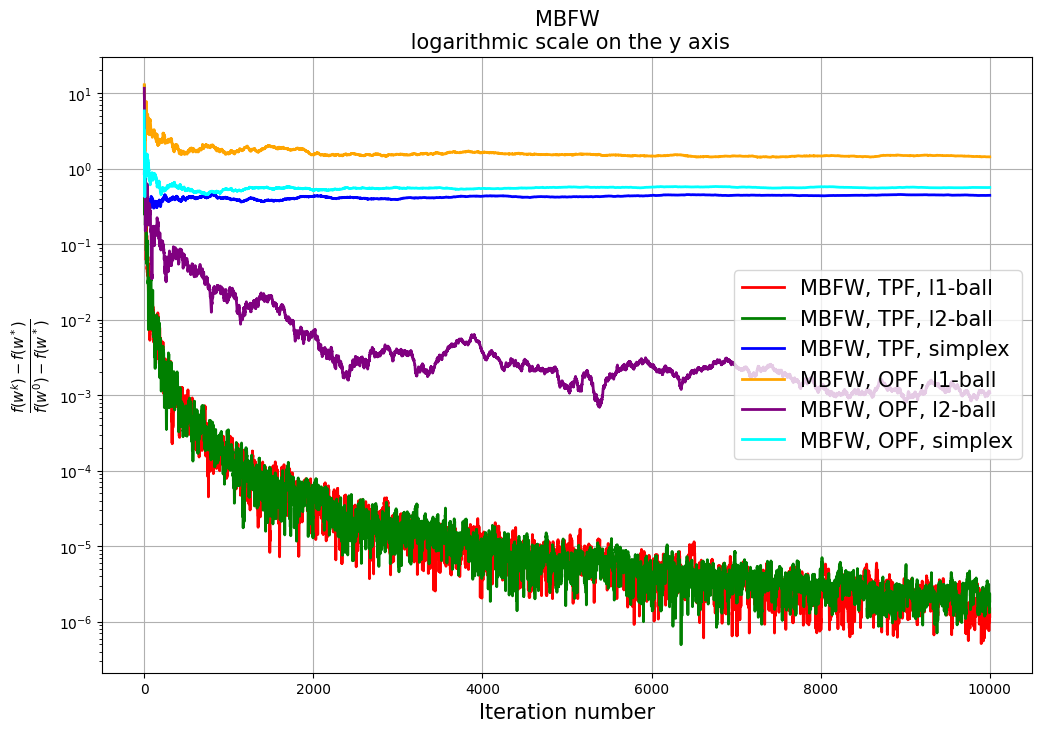

In [ ]:
title = "MBFW"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

iterations_mbfw = iterations_mbfw_tpf_l1 + iterations_mbfw_tpf_l2 + iterations_mbfw_tpf_s + \
                  iterations_mbfw_opf_l1 + iterations_mbfw_opf_l2 + iterations_mbfw_opf_s
errors_mbfw = errors_mbfw_tpf_l1 + errors_mbfw_tpf_l2 + errors_mbfw_tpf_s + \
              errors_mbfw_opf_l1 + errors_mbfw_opf_l2 + errors_mbfw_opf_s
labels_mbfw = labels_mbfw_tpf_l1 + labels_mbfw_tpf_l2 + labels_mbfw_tpf_s + \
              labels_mbfw_opf_l1 + labels_mbfw_opf_l2 + labels_mbfw_opf_s

optimizers.make_err_plot(iterations_mbfw, errors_mbfw, y_label=y_label,
                     labels=labels_mbfw, title=title, markers=[None]*100)

# FW

In [ ]:
reload(optimizers)


title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1

optimizer = optimizers.FWOptimizer(f, optimizers.get_grad_tpf_jaguar, 
                                     x_0 = w_0, step = fw_step, args = args)

label = 'FW, TPF, l1-ball'
args['proj'] = 'l1'

iterations_fw_tpf_l1, errors_fw_tpf_l1, labels_fw_tpf_l1, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)
label = 'FW, TPF, l2-ball'
args['proj'] = 'l2'

iterations_fw_tpf_l2, errors_fw_tpf_l2, labels_fw_tpf_l2, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)
label = 'FW, TPF, simplex'
args['proj'] = 'simplex'

iterations_fw_tpf_s, errors_fw_tpf_s, labels_fw_tpf_s, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)


100%|██████████| 10000/10000 [00:01<00:00, 7577.99it/s]


In [ ]:
reload(optimizers)


title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1

optimizer = optimizers.FWOptimizer(f, optimizers.get_grad_opf_jaguar, 
                                     x_0 = w_0, step = fw_step, args = args)

label = 'FW, OPF, l1-ball'
args['proj'] = 'l1'

iterations_fw_opf_l1, errors_fw_opf_l1, labels_fw_opf_l1, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)
label = 'FW, OPF, l2-ball'
args['proj'] = 'l2'

iterations_fw_opf_l2, errors_fw_opf_l2, labels_fw_opf_l2, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)
label = 'FW, OPF, simplex'
args['proj'] = 'simplex'

iterations_fw_opf_s, errors_fw_opf_s, labels_fw_opf_s, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)


100%|██████████| 10000/10000 [00:01<00:00, 9663.47it/s]


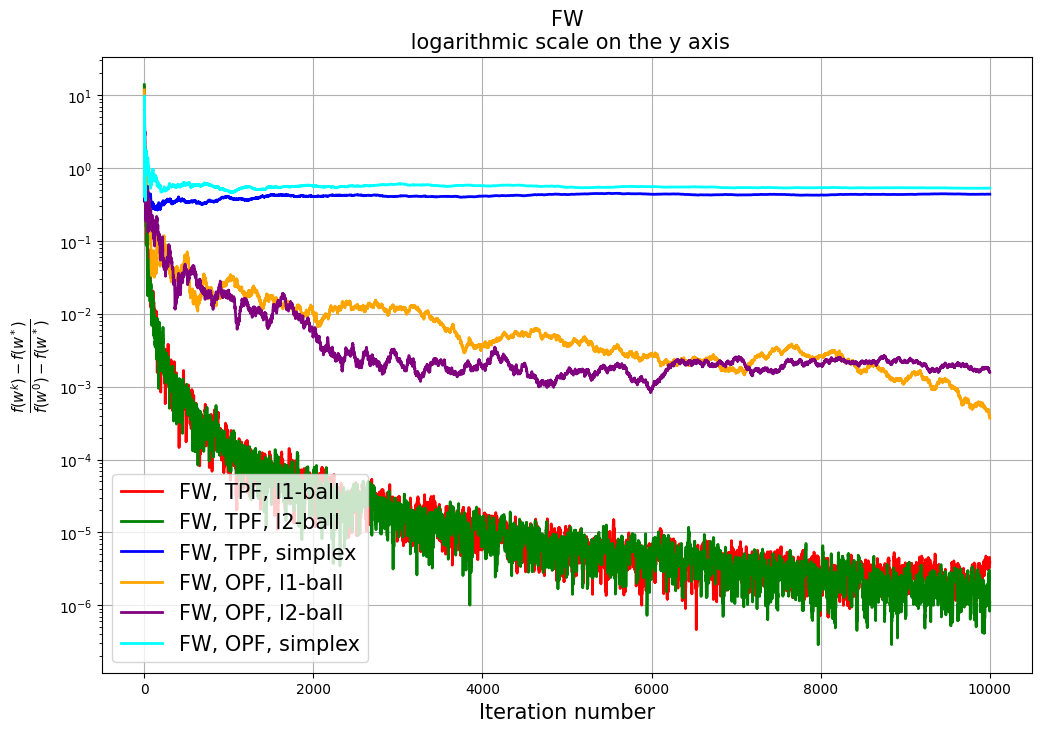

In [ ]:
title = "FW"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

iterations_fw = iterations_fw_tpf_l1 + iterations_fw_tpf_l2 + iterations_fw_tpf_s + \
                  iterations_fw_opf_l1 + iterations_fw_opf_l2 + iterations_fw_opf_s
errors_fw = errors_fw_tpf_l1 + errors_fw_tpf_l2 + errors_fw_tpf_s + \
              errors_fw_opf_l1 + errors_fw_opf_l2 + errors_fw_opf_s
labels_fw = labels_fw_tpf_l1 + labels_fw_tpf_l2 + labels_fw_tpf_s + \
              labels_fw_opf_l1 + labels_fw_opf_l2 + labels_fw_opf_s

optimizers.make_err_plot(iterations_fw, errors_fw, y_label=y_label,
                     labels=labels_fw, title=title, markers=[None]*100)

# Projection

## finding x_sol

In [ ]:
def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / (500 * args['L'])

In [ ]:
reload(optimizers)

args['max_steps'] = 10 ** 5
args['proj'] = False
args['batch_size'] = 1

args['x_sol'] = w_0

args['x_sol'], _ , _ = optimizers.GDOptimizer(f, gradient_true, x_0 = w_0, step = const_gamma, args = args).search()

w_sol_true = args['x_sol']
R_0 = f(w_0, args) - f(w_sol_true, args)

100%|██████████| 100000/100000 [00:03<00:00, 26986.90it/s]


In [ ]:
reload(optimizers)


title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1

optimizer = optimizers.GDOptimizer(f, optimizers.get_grad_tpf_jaguar, 
                                     x_0 = w_0, step = const_gamma, args = args)

label = 'Proj, TPF, l1-ball'
args['proj'] = 'l1'

iterations_proj_tpf_l1, errors_proj_tpf_l1, labels_proj_tpf_l1, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)
label = 'Proj, TPF, l2-ball'
args['proj'] = 'l2'

iterations_proj_tpf_l2, errors_proj_tpf_l2, labels_proj_tpf_l2, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)
label = 'Proj, TPF, simplex'
args['proj'] = 'simplex'

iterations_proj_tpf_s, errors_proj_tpf_s, labels_proj_tpf_s, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)


100%|██████████| 10000/10000 [00:01<00:00, 9325.62it/s]


In [ ]:
reload(optimizers)


title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1

optimizer = optimizers.GDOptimizer(f, optimizers.get_grad_opf_jaguar, 
                                     x_0 = w_0, step = const_gamma, args = args)

label = 'Proj, OPF, l1-ball'
args['proj'] = 'l1'

iterations_proj_opf_l1, errors_proj_opf_l1, labels_proj_opf_l1, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)
label = 'Proj, OPF, l2-ball'
args['proj'] = 'l2'

iterations_proj_opf_l2, errors_proj_opf_l2, labels_proj_opf_l2, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)
label = 'Proj, OPF, simplex'
args['proj'] = 'simplex'

iterations_proj_opf_s, errors_proj_opf_s, labels_proj_opf_s, _ = calculate(args, optimizer, 
                                                                 R_0, label, title)


100%|██████████| 10000/10000 [00:00<00:00, 10538.48it/s]


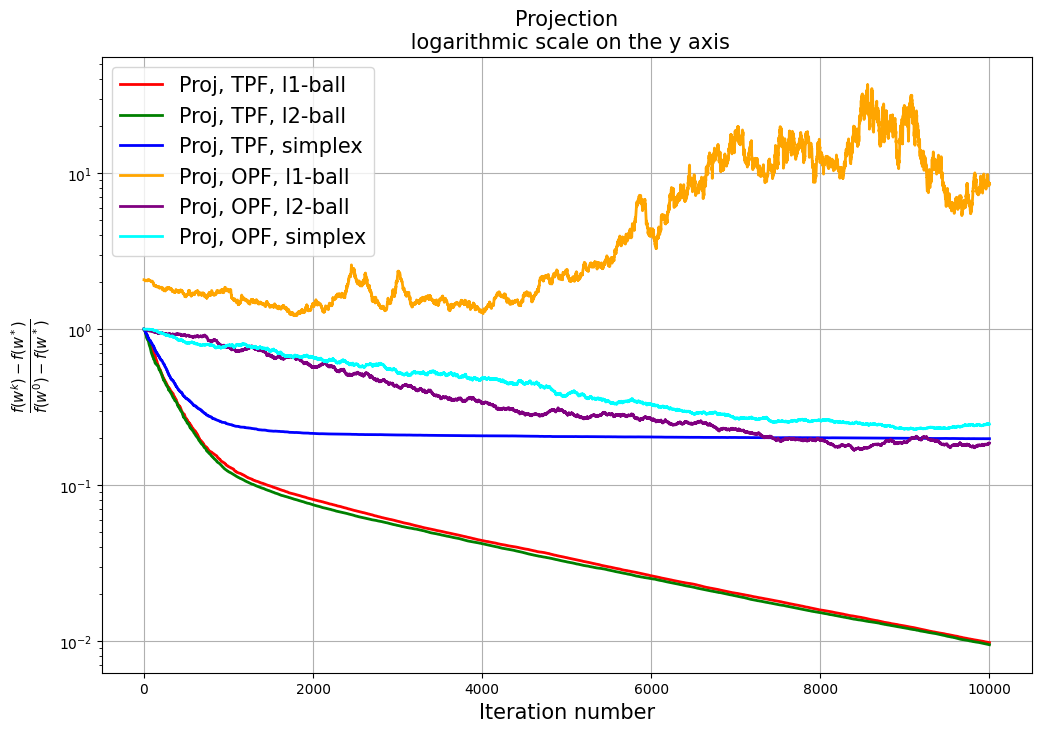

In [ ]:
title = "Projection"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

iterations_proj = iterations_proj_tpf_l1 + iterations_proj_tpf_l2 + iterations_proj_tpf_s + \
                  iterations_proj_opf_l1 + iterations_proj_opf_l2 + iterations_proj_opf_s
errors_proj = errors_proj_tpf_l1 + errors_proj_tpf_l2 + errors_proj_tpf_s + \
              errors_proj_opf_l1 + errors_proj_opf_l2 + errors_proj_opf_s
labels_proj = labels_proj_tpf_l1 + labels_proj_tpf_l2 + labels_proj_tpf_s + \
              labels_proj_opf_l1 + labels_proj_opf_l2 + labels_proj_opf_s

optimizers.make_err_plot(iterations_proj, errors_proj, y_label=y_label,
                     labels=labels_proj, title=title, markers=[None]*100)

# Mirror Descent